In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import voxelmorph as vxm
import matplotlib.pyplot as plt
import os
import numpy as np
import neurite as ne
from glob import glob
import subtle.utils.io as suio
import h5py
from tqdm import tqdm_notebook as tqdm
from subtle.subtle_preprocess import center_crop, get_brain_portion
from scipy.ndimage.interpolation import zoom as zoom_interp
import pydicom
from glob import glob


plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

def correct_shapes(img):
    ref_x, ref_y = (192, 224)
    if img.shape[1] != ref_x or img.shape[2] != ref_y:
        return center_crop(img, np.zeros((img.shape[0], ref_x, ref_y)))
    return img

def preprocess_vmorph(ip_vol):
    subj1 = np.load('/home/srivathsa/projects/studies/gad/vmorph/tutorial_data/subj1.npz')['vol']
    
    pre_img, low_img = ip_vol
    pre_img = np.flip(pre_img, axis=2)
    low_img = np.flip(low_img, axis=2)
    
    zdiff = (pre_img.shape[0] - 160)
    if zdiff % 2 == 0:
        z1 = zdiff // 2
        z2 = zdiff // 2
    else:
        z1 = zdiff // 2
        z2 = z1 + 1
    
    pre_crop, _ = get_brain_portion(pre_img[z1:-z2], threshold=0.1)
    low_crop, _ = get_brain_portion(low_img[z1:-z2], threshold=0.1)
    
    xmax = 151
    ymax = 174
    
    xdiff = (xmax - pre_crop.shape[1])
    ydiff = (ymax - pre_crop.shape[2])
    
    if xdiff % 2 == 0:
        xc1 = xdiff // 2
        xc2 = xdiff // 2
    else:
        xc1 = xdiff // 2
        xc2 = xc1 + 1
    
    if ydiff % 2 == 0:
        yc1 = ydiff // 2
        yc2 = ydiff // 2
    else:
        yc1 = ydiff // 2
        yc2 = yc1 + 1
    
    crop_std = [(0, 0), (xc1, xc2), (yc1, yc2)]
    
    pre_crop = np.pad(pre_crop, pad_width=crop_std, mode='constant', constant_values=0)
    low_crop = np.pad(low_crop, pad_width=crop_std, mode='constant', constant_values=0)
    
    pwidth = [(0, 0), (17, 17), (20, 21)]

    pre_crop = zoom_interp(pre_crop, (1, 1.12, 1.063))
    low_crop = zoom_interp(low_crop, (1, 1.12, 1.063))

    pre_crop = np.clip(pre_crop, 0, pre_crop.max())
    low_crop = np.clip(low_crop, 0, low_crop.max())

    pre_final = np.pad(pre_crop, pad_width=pwidth, mode='constant', constant_values=0)
    low_final = np.pad(low_crop, pad_width=pwidth, mode='constant', constant_values=0)

    pre_final = np.interp(pre_final, (pre_final.min(), pre_final.max()), (subj1.min(), subj1.max()))
    low_final = np.interp(low_final, (low_final.min(), low_final.max()), (subj1.min(), subj1.max()))
    
    pre_final = correct_shapes(pre_final)
    low_final = correct_shapes(low_final)
    
    return np.array([pre_final, low_final])

def sort_dcm(fpath):
    return int(pydicom.dcmread(fpath).InstanceNumber)

def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))], key=sort_dcm)
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

Using TensorFlow backend.
/home/srivathsa/miniconda3/envs/voxelmorph/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/srivathsa/miniconda3/envs/voxelmorph/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/srivathsa/miniconda3/envs/voxelmorph/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

<Figure size 432x288 with 0 Axes>

In [2]:
train_files = vxm.py.utils.read_file_list('/home/srivathsa/projects/studies/gad/vmorph/image_lists/nonrigid_post/train_post.txt')

In [3]:
vgen = vxm.generators.volgen(train_files)

In [4]:
data = next(vgen)

# plt.imshow(data[0][0, 128, ..., 0])

In [5]:
generator = vxm.generators.scan_to_scan(train_files, batch_size=1)

item = next(generator)
item[1][1].shape

(1, 2, 160, 192, 224, 4)

In [6]:
sample_shape = next(generator)[0][0].shape
inshape = sample_shape[1:-1]
nfeats = sample_shape[-1]

enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

# enc_nf = [8, 16, 16, 16]
# dec_nf = [16, 16, 16, 16, 16, 8, 8]

In [7]:
model = vxm.networks.VxmDense(
    inshape=(160, 192, 224),
    nb_unet_features=[enc_nf, dec_nf],
    bidir=False,
    use_probs=False,
    int_steps=7,
    int_downsize=2,
    src_feats=nfeats,
    trg_feats=nfeats
)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary(line_length=120)

Model: "vxm_dense"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
vxm_dense_source_input (InputLayer)    [(None, 160, 192, 224, 1)] 0                                                     
________________________________________________________________________________________________________________________
vxm_dense_target_input (InputLayer)    [(None, 160, 192, 224, 1)] 0                                                     
________________________________________________________________________________________________________________________
vxm_dense_unet_input_concat (Concatena (None, 160, 192, 224, 2)   0             vxm_dense_source_input[0][0]            
                                                                                vxm_dense_target_input[0][0]            
_____________

In [9]:
model.load_weights('/home/srivathsa/projects/studies/gad/vmorph/tutorial_data/brain_3d.h5')

0.0 0.70980394


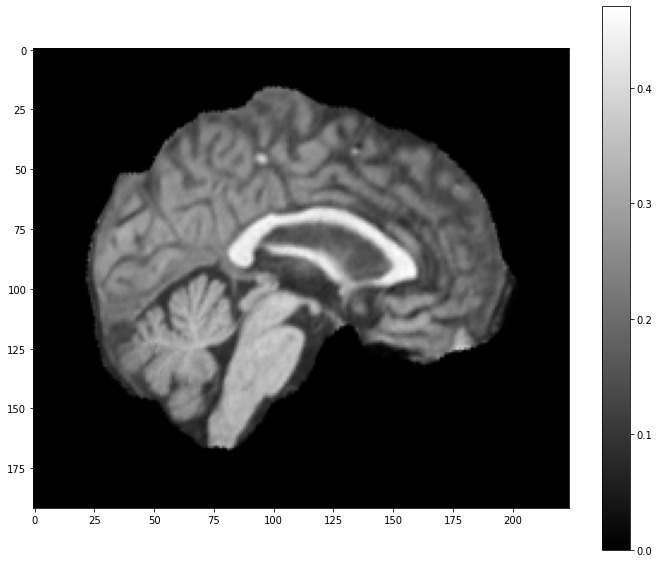

In [10]:
subj1 = np.load('/home/srivathsa/projects/studies/gad/vmorph/tutorial_data/subj1.npz')['vol']
subj2 = np.load('/home/srivathsa/projects/studies/gad/vmorph/tutorial_data/subj2.npz')['vol']

plt.imshow(subj2[80])
print(subj1.min(), subj1.max())
plt.colorbar()

In [11]:
ip1 = subj1[..., None]
ip2 = subj2[..., None]
ip = [[ip1], [ip2]]

In [12]:
pred = model.predict(ip)

In [13]:
print(pred[0].shape)

(1, 160, 192, 224, 1)


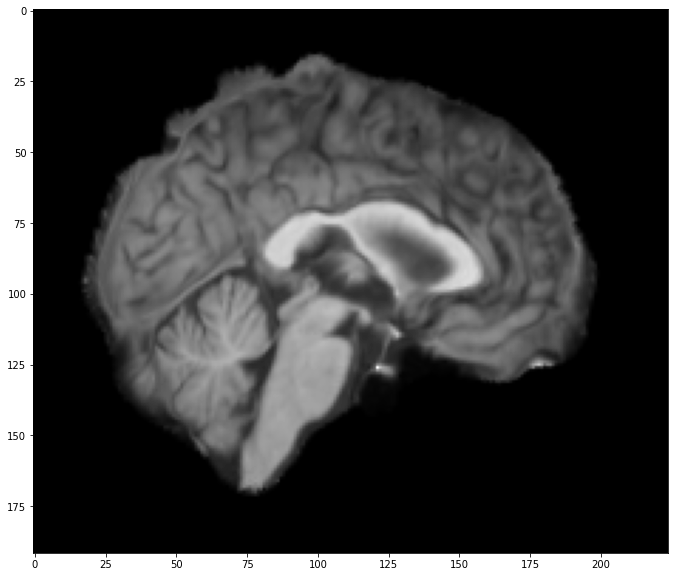

In [14]:
plt.imshow(pred[0][0, 80, ..., 0])

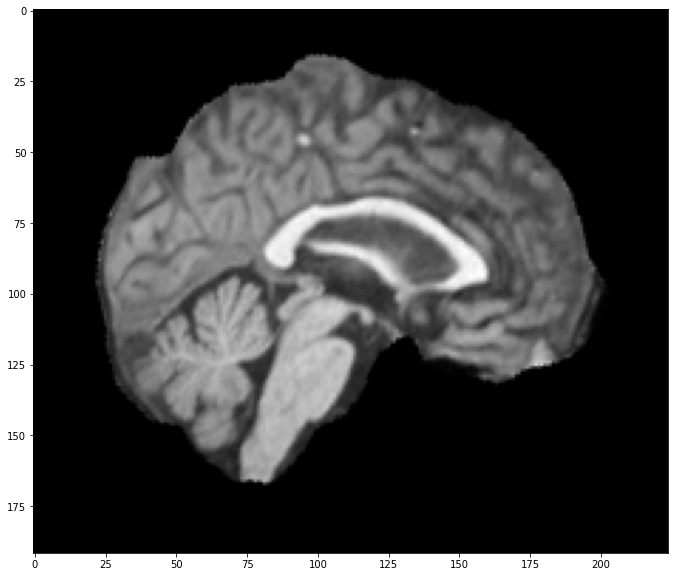

In [15]:
plt.imshow(subj2[80])

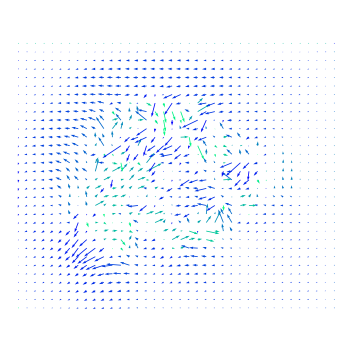

(<Figure size 360x360 with 1 Axes>, [<AxesSubplot:>])

In [16]:
flow = pred[1].squeeze()[16, ::3,::3, 1:3]
ne.plot.flow([flow], width=5)

In [ ]:
pre, _ = suio.dicom_files('/home/srivathsa/projects/studies/gad/tiantan/data/NO101/3DT1_C+_CS4.5_Series_601')
low, _ = suio.dicom_files('/home/srivathsa/projects/studies/gad/tiantan/data/NO101/3DT1_C+_CS4.5_Series_801')

In [ ]:
mask = np.load('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/hdbet_masks/NO101.npy')

pre_mask = pre * mask
low_mask = low * mask

pre_mask = pre_mask[18:-18, :-48, 8:-8]
low_mask = low_mask[18:-18, :-48, 8:-8]

pre_mask = np.interp(pre_mask, (pre_mask.min(), pre_mask.max()), (0, 1))
low_mask = np.interp(low_mask, (low_mask.min(), low_mask.max()), (0, 1))

ip1 = pre_mask[..., None]
ip2 = low_mask[..., None]
ip = [[ip2], [ip1]]

pred, field = model.predict(ip)


In [ ]:
plt.imshow(low_mask[80] - pre_mask[80])

In [ ]:
plt.imshow(pred[0, 80, ..., 0] - pre_mask[80])

In [ ]:
plt.imshow(np.hstack([pred[0, 80, ..., 0], pre_mask[80], low_mask[80], np.abs(pred[0, 80, ..., 0] - low_mask[80])]))

In [ ]:
flow = field.squeeze()[16, ::3,::3, 1:3]
ne.plot.flow([flow], width=5)

In [ ]:
data = np.load('/home/srivathsa/projects/studies/gad/vmorph/tutorial_data/subj1.npz')
print(data['seg'].shape)

In [ ]:
plt.imshow(data['vol'][:, 90])
plt.colorbar()

In [ ]:
cases = ['Brain2H-600441599', 'Brain3H-600437593', 'Brain4H-601044594', 'Brain5H-601047608', 'Case1',
         'NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'NO6', 'NO7', 'NO8', 'NO9', 'NO10', 'NO11', 
         'NO12', 'NO13', 'NO14', 'NO15', 'NO16', 'NO17', 'NO18', 'NO19', 'NO20', 'NO21', 
         'NO22', 'NO23', 'NO24', 'NO25', 'NO26', 'NO27', 'NO28', 'NO29', 'NO30', 'NO31', 
         'NO32', 'NO33', 'NO34', 'NO35', 'NO36', 'NO37', 'NO38', 'NO39', 'NO40', 'NO41', 
         'NO42', 'NO43', 'NO44', 'NO45', 'NO46', 'NO47', 'NO48', 'NO49', 'NO50', 'NO51', 
         'NO52', 'NO53', 'NO54', 'NO55', 'NO56', 'NO57', 'NO58', 'NO59', 'NO60', 'NO61', 
         'NO62', 'NO63', 'NO64', 'NO65', 'NO66', 'NO67', 'NO68', 'NO69', 'NO70', 'NO71', 
         'NO72', 'NO73', 'NO74', 'NO75', 'NO76', 'NO77', 'NO78', 'NO79', 'NO80', 'NO81', 
         'NO82', 'NO83']
src_path = '/home/srivathsa/projects/studies/gad/vmorph/affine_data'
# cases = ['NO47', 'NO54', 'NO55', 'NO77']
# cases = ['NO101', 'NO102', 'NO103', 'NO104', 'NO105']
dest_path = '/home/srivathsa/projects/studies/gad/vmorph/affine_data/sc'
ref_img = np.zeros((2, 160, 192, 224))
for cnum in tqdm(cases, total=len(cases)):
#     data = suio.load_file('{}/{}.h5'.format(src_path, cnum), params={'h5_key': 'all'})
    data = np.load('{}/{}.npz'.format(src_path, cnum))['data']
#     data = np.interp(data, (data.min(), data.max()), (0, 1))
#     np.savez('{}/{}.npz'.format(dest_path, cnum), data=data)
#     save_data = data[1, :, :2].transpose(1, 0, 2, 3)
#     save_data = np.interp(save_data, (save_data.min(), save_data.max()), (-1, 1))
#     save_data = data[1, :, [0, 2]]
#     proc_data = preprocess_vmorph(save_data)
#     np.savez('{}/{}.npz'.format(dest_path, cnum), data=save_data)

In [ ]:
dcm_path = '/home/srivathsa/projects/studies/gad/tiantan/data'
for cnum in tqdm(cases, total=len(cases)):
    dirpath_pre, dirpath_low, _ = suio.get_dicom_dirs('{}/{}'.format(dcm_path, cnum), override=True)
    pre_con, _ = suio.dicom_files(dirpath_pre)
    low_con, _ = suio.dicom_files(dirpath_low)
    save_data = np.array([pre_con, low_con])
    proc_data = preprocess_vmorph(save_data)
    print(proc_data.shape)
    break

In [ ]:
src_path = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data'
data_files = sorted([f for f in glob('{}/*.h5'.format(src_path)) if 'meta' not in f and 'Prisma' not in f and 'TwoDim' not in f])
case_nums = []
for df in data_files:
    if 'NO' not in df or 'mod' in df:
        continue
    case_num = df.split('/')[-1].replace('.h5', '')
    case_nums.append(case_num)
case_nums = sorted(case_nums, key=lambda c: int(c.replace('NO', '')))

In [ ]:
# proc_data = preprocess_vmorph(save_data)
cases = ['Brain2H-600441599', 'Brain3H-600437593', 'Brain4H-601044594', 'Brain5H-601047608', 'Case1',
         'NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'NO6', 'NO7', 'NO8', 'NO9', 'NO10', 'NO11', 
         'NO12', 'NO13', 'NO14', 'NO15', 'NO16', 'NO17', 'NO18', 'NO19', 'NO20', 'NO21', 
         'NO22', 'NO23', 'NO24', 'NO25', 'NO26', 'NO27', 'NO28', 'NO29', 'NO30', 'NO31', 
         'NO32', 'NO33', 'NO34', 'NO35', 'NO36', 'NO37', 'NO38', 'NO39', 'NO40', 'NO41', 
         'NO42', 'NO43', 'NO44', 'NO45', 'NO46', 'NO47', 'NO48', 'NO49', 'NO50', 'NO51', 
         'NO52', 'NO53', 'NO54', 'NO55', 'NO56', 'NO57', 'NO58', 'NO59', 'NO60', 'NO61', 
         'NO62', 'NO63', 'NO64', 'NO65', 'NO66', 'NO67', 'NO68', 'NO69', 'NO70', 'NO71', 
         'NO72', 'NO73', 'NO74', 'NO75', 'NO76', 'NO77', 'NO78', 'NO79', 'NO80', 'NO81', 
         'NO82', 'NO83']
max_x = 0
max_y = 0

cases = ['NO79', 'NO78', 'NO70', 'NO67', 'NO44', 'NO39', 'NO34', 'NO27', 'NO23']
for cnum in cases:
    data = suio.load_file('{}/{}.h5'.format(src_path, cnum), params={'h5_key': 'all'})
    save_data = data[1, :, :2].transpose(1, 0, 2, 3)
#     proc_data = preprocess_vmorph(save_data)

    pre_crop, _ = get_brain_portion(save_data[0], threshold=0.1)
    low_crop, _ = get_brain_portion(save_data[1], threshold=0.1)

    print(cnum, pre_crop.shape, low_crop.shape)
    if pre_crop.shape[1] > max_x:
        max_x = pre_crop.shape[1]
    if pre_crop.shape[2] > max_y:
        max_y = pre_crop.shape[2]
print(max_x, max_y)
# plt.imshow(low_crop[98])

In [ ]:
crop_img, _ = get_brain_portion(save_data[0], threshold=0.1)
print(crop_img.shape)
plt.imshow(crop_img[98])

In [ ]:
cases = ['Brain2H-600441599', 'Brain3H-600437593', 'Brain4H-601044594', 'Brain5H-601047608', 'Case1',
         'NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'NO6', 'NO7', 'NO8', 'NO9', 'NO10', 'NO11', 
         'NO12', 'NO13', 'NO14', 'NO15', 'NO16', 'NO17', 'NO18', 'NO19', 'NO20', 'NO21', 
         'NO22', 'NO23', 'NO24', 'NO25', 'NO26', 'NO27', 'NO28', 'NO29', 'NO30', 'NO31', 
         'NO32', 'NO33', 'NO34', 'NO35', 'NO36', 'NO37', 'NO38', 'NO39', 'NO40', 'NO41', 
         'NO42', 'NO43', 'NO44', 'NO45', 'NO46', 'NO47', 'NO48', 'NO49', 'NO50', 'NO51', 
         'NO52', 'NO53', 'NO54', 'NO55', 'NO56', 'NO57', 'NO58', 'NO59', 'NO60', 'NO61', 
         'NO62', 'NO63', 'NO64', 'NO65', 'NO66', 'NO67', 'NO68', 'NO69', 'NO70', 'NO71', 
         'NO72', 'NO73', 'NO74', 'NO75', 'NO76', 'NO77', 'NO78', 'NO79', 'NO80', 'NO81', 
         'NO82', 'NO83']
dest_path = '/home/srivathsa/projects/studies/gad/vmorph/proc_data'
for cnum in cases:
    data = np.load('{}/{}.npz'.format(dest_path, cnum))['data']
    if data.shape[1] != 160:
        print(cnum, data.shape)

In [ ]:
subj_crop, _ = get_brain_portion(subj1)
print(subj1.shape)
print(subj_crop.shape)

In [ ]:
data_loader = vxm.generators.SubtleGadLoader('/home/srivathsa/projects/studies/gad/vmorph/train.txt')

In [ ]:
x, y = data_loader.__getitem__(0)
print(y[1].shape)

In [ ]:
d = np.load('/home/srivathsa/projects/studies/gad/vmorph/proc_data/Brain2H-600441599.npz')
d['data']

In [ ]:
orig_data = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO77.h5')
print(orig_data.shape)

In [ ]:
cases = ['Brain2H-600441599', 'Brain3H-600437593', 'Brain4H-601044594', 'Brain5H-601047608', 'Case1',
         'NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'NO6', 'NO7', 'NO8', 'NO9', 'NO10', 'NO11', 
         'NO12', 'NO13', 'NO14', 'NO15', 'NO16', 'NO17', 'NO18', 'NO19', 'NO20', 'NO21', 
         'NO22', 'NO23', 'NO24', 'NO25', 'NO26', 'NO27', 'NO28', 'NO29', 'NO30', 'NO31', 
         'NO32', 'NO33', 'NO34', 'NO35', 'NO36', 'NO37', 'NO38', 'NO39', 'NO40', 'NO41', 
         'NO42', 'NO43', 'NO44', 'NO45', 'NO46', 'NO47', 'NO48', 'NO49', 'NO50', 'NO51', 
         'NO52', 'NO53', 'NO54', 'NO55', 'NO56', 'NO57', 'NO58', 'NO59', 'NO60', 'NO61', 
         'NO62', 'NO63', 'NO64', 'NO65', 'NO66', 'NO67', 'NO68', 'NO69', 'NO70', 'NO71', 
         'NO72', 'NO73', 'NO74', 'NO75', 'NO76', 'NO77', 'NO78', "NO79", 'NO80', 'NO81', 'NO82', 'NO83']
cases = ['NO101', 'NO102', 'NO103', 'NO104', 'NO105']
src_path = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/vmorph_noreg'
plot_dest = '/home/srivathsa/projects/studies/gad/vmorph/pre_reg_plots'

for cnum in tqdm(cases, total=len(cases)):
    data = suio.load_file('{}/{}.h5'.format(src_path, cnum), params={'h5_key': 'all'})[1]
    pre_con, low_con, _ = data.transpose(1, 0, 2, 3)
    sl = pre_con.shape[0] // 2
#     plt.imshow(low_con[sl] - pre_con[sl])
    plt.imshow(np.hstack([pre_con[sl], low_con[sl]]))
    plt.savefig('{}/{}_prelow.png'.format(plot_dest, cnum))
    plt.clf()

In [ ]:
data = np.load('/home/srivathsa/projects/studies/gad/vmorph/affine_data/NO77.npz'.format(cnum))['data']
data_rs = np.pad(data, pad_width=[(0, 0), (8, 8), (0, 0), (0, 0)])
print(data_rs.shape)
np.savez('/home/srivathsa/projects/studies/gad/vmorph/affine_data/NO77_rs.npz', data=data_rs)


# plt.imshow(np.hstack([data[0, 80], data[1, 80]]))
# print(data[0].min(), data[0].max())
# print(data[1].min(), data[1].max())

In [ ]:
src_path = '/home/srivathsa/projects/studies/gad/vmorph/affine_data'
dest_path = '/home/srivathsa/projects/studies/gad/vmorph/affine_data/im_256'
fpaths = sorted([f for f in glob('{}/*.npz'.format(src_path))])

for fpath in tqdm(fpaths, total=len(fpaths)):
    cnum = fpath.split('/')[-1].replace('.npz', '')
    data = np.load(fpath)['data']
    print(data.min(), data.max())
    data_rs = np.pad(data, pad_width=[(0, 0), (30, 30), (8, 8), (8, 8)], mode='constant', constant_values=data.min())
    np.savez('{}/{}.npz'.format(dest_path, cnum), data=data_rs)